# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black;"><strong>Module importations</strong></span>

In [1]:
from MyModule import *

In [2]:
%run GUI_animal_selection.py

P:\SharedFiles\Abdussamed\Pulvinar_rec_dark_80degs\phototagging_rotation_pitch_dark\animal21_a19d1s1_ephys\21a19d1s1_210403_130057


In [3]:
try:
    print("Saving_boolean: ", Saving_boolean)
except NameError:
    Saving_boolean = True

True


In [4]:
## qt for popup window (savable as pdf, svg...), inline for inline plot, notebook for interactive plot, widget for interactive plot
#%matplotlib widget 
#plt.ioff()
## plt.rcdefaults()

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>FUNCTIONS</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plots(row_number, col_number, width, height, *args, suptitle=None,**kwargs)</strong></span>

In [5]:
def plots(*plot_commands, ncols=None, suptitle=None, supxlabel=None, supylabel=None, size=(9, 5), show=True, save=False, filename=None):
    num_plots = len(plot_commands)
    if ncols is None:
        ncols = int(num_plots ** 0.5) + 1  # Calcul automatique du nombre de colonnes

    nrows = (num_plots + ncols - 1) // ncols

    fig = plt.figure(figsize=size)
    # Création des sous-figures
    for i, command in enumerate(plot_commands, start=1):
        plt.subplot(nrows, ncols, i)
        exec(command)

    
    if supxlabel:
        fig.supxlabel(supxlabel)
    if supylabel:
        fig.supylabel(supylabel)
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)

    if show:
        plt.show()
    else:
        plt.close(fig)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotPSTH(StudiedSpikeTimes)</strong></span>

In [6]:
def getPSTHparameters(StudiedSpikeTimes, timeObject, binResolution):
    local_trial_number = len(StudiedSpikeTimes)

    spike_number_per_trial = [[] for _ in range(local_trial_number)]
    edges = []

    for trial in range(local_trial_number):
        spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(timeObject[0], round(timeObject[-1])+binResolution, binResolution))


    frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
    mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]
    baseline_mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1) if edges[bin] < 0]

    Zscore = (mean_frequency - np.mean(baseline_mean_frequency)) / np.std(baseline_mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
    Zscore[-1]=Zscore[-2]
    Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
    SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))

    return edges, Zscore, SEM

In [7]:
def plotPSTH(SpikeTimesObject, unit, color='k',shadedcolor='c',binResolution = 0.03,xlabel=True,ylabel=True, title='', xlim=None, save=False, filename='PSTH.png', show=True, smooth=True, Plots=False):
    if type(unit)==list:
        StudiedSpikeTimes = np.concatenate([SpikeTimesObject[i] for i in unit])
    else:
        StudiedSpikeTimes = SpikeTimesObject[unit]
    
    timeDuration = duration
    
    edges, Zscore, SEM = getPSTHparameters(StudiedSpikeTimes, timeDuration, binResolution)

    if smooth:
        Zscore = savgol_filter(Zscore, 9, 3)

    if not Plots:
        plt.figure()

    plt.plot(edges[:-1], Zscore, color=color)
    plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
    if xlim:
        plt.xlim(xlim)
    else:
        plt.margins(x=0)
    if ylabel:
        plt.ylabel('Z-Score FR')
    if xlabel:
        plt.xlabel('Time (s)')

    plt.title(title)

    if save:
        plt.savefig(filename, bbox_inches='tight')

    if not Plots:
        if show:
            plt.show()
        else:
            plt.close()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>plotRaster(spikeTimesObject)</strong></span>

In [8]:
def plotRaster(SpikeTimesObject, unit, color='black', xlabel='Time (s)', ylabel='# Trial', title='', xlim=None, save=False, filename='Raster.png', show=True, psth=False, binResolution=0.03, shadedcolor='red', psthcolor='red', smooth=True, Plots=False):
    if type(unit)==list:
        StudiedSpikeTimes = np.concatenate([SpikeTimesObject[i] for i in unit])
    else:
        StudiedSpikeTimes = SpikeTimesObject[unit]

    linelengths = 1


    if not Plots:
        plt.figure()
        
    plt.eventplot(StudiedSpikeTimes, linelengths=linelengths, colors=color)

    
    ### annulate the offset due to python indexation
    def custom_formatter(x, pos):
        return f"{int(x) + 1}"
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))


    if xlim:
        plt.xlim(xlim)
    else:
        plt.margins(x=0)
    plt.ylim(0-linelengths/2,len(StudiedSpikeTimes)-1+linelengths/2)

    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    plt.title(title)

    if psth:
        edges, Zscore, SEM = getPSTHparameters(StudiedSpikeTimes, duration, binResolution)
        if smooth:
            Zscore = savgol_filter(Zscore, 9, 3)
        plt.twinx()
        plt.plot(edges[:-1], Zscore, color=psthcolor)
        plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
        if ylabel:
            plt.ylabel('Z-Score FR')
        if xlabel:
            plt.xlabel('Time (s)')

    if save:
        plt.savefig(filename, bbox_inches='tight')
        
    if not Plots:
        if show:
            plt.show()
        else:
            plt.close()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>split_path(path)</strong></span>

In [9]:
def split_path(path):
    drive, path_without_drive = os.path.splitdrive(path)
    path_segments = []
    while True:
        head, tail = os.path.split(path_without_drive)
        if tail:
            path_segments.insert(0, tail)
            path_without_drive = head
        else:
            if head:
                path_segments.insert(0, head)
            break
    path_segments.insert(0, drive)
    return path_segments

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Find Peaks</strong></span>

In [10]:
def find_peaks(studiedRef, f):
    centered_peaks, _ = scipy.signal.find_peaks(studiedRef, plateau_size=(0.3*f,5*f))

    AllPeaks, _ = scipy.signal.find_peaks(np.diff(studiedRef))

    peaks = []
    for center_pic in centered_peaks:
        peaks.append(AllPeaks[(AllPeaks > center_pic - 3 * f) & (AllPeaks < center_pic)][0])

    return peaks

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Initiation</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Paths</strong></span>

In [11]:
parent_folder = os.path.dirname(raw_data_path)

exp_id = raw_data_path[raw_data_path.find('animal'):raw_data_path.find('animal')+len('animal')+10]

saving_folder = fr'C:\Users\gbouvier\Documents\Analyses\{exp_id}\phototagging'
os.makedirs(saving_folder, exist_ok=True)

print(exp_id.upper(), '-- Phototagging analysis')

ANIMAL21_A19D1S1 -- Phototagging analysis


## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Determination of Parameters</strong></span>

In [12]:
census_data = pd.read_excel(r'C:\Users\gbouvier\Documents\census.xlsx', sheet_name=None)

In [13]:
timeBef = 1
timeAft = 3


ProbeType         = census_data['Study']['ElectrodeType'][census_data['Study']['exp_id']==exp_id].iloc[0]
chanSpace         = census_data['Electrodes']['Channel_z_distance'][census_data['Electrodes']['Name']==ProbeType].iloc[0]   # um

refValue          = 'din04'
rotationSpeed     = 80                 #deg/s


## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Data Importation</strong></span>

### For MUA

In [14]:
times_polytrodeAll = scipy.io.loadmat(os.path.join(raw_data_path, 'times_polytrodeAll.mat'))
m_class = times_polytrodeAll['mua_class']
'''
m_class[:,0] : indice of the cluster for each index
m_class[:,1] : time of the spike in ms
m_class[:,1]/1000 : time of the spike in s
'''

muaWf = times_polytrodeAll['clusWFmua']

In [15]:
fig = go.Figure()

for unit in range(len(muaWf)):
    x = np.arange(0 + 70 * unit, 54 + 70 * unit)
    for i in range(muaWf[unit].shape[1]):
        y = muaWf[unit][:, i]
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=f'Unit {unit}'))
        if unit == 0 and i == 0:
            fig.update_layout(title=exp_id)

fig.write_html(os.path.join(saving_folder, 'spike_waveform.html'))

### For SUA

In [16]:
c_class = times_polytrodeAll['cluster_class']  # units and associated time spiking

temp_idx = c_class[:,0]    # units

# find the units and remove the MUA
units = temp_idx!=0
temp_clus = c_class[units,0]

Nclust = len(np.unique(temp_clus))

temp_time = c_class[units,1]/1000  # temps de spike en seconde

temp_time_clust = []

for unit in range(Nclust):
    temps_spikes_sec = c_class[np.where(c_class[:,0]==unit+1)][:,1] / 1000
    temp_time_clust.append(temps_spikes_sec)

### General

In [17]:
clusterParam = h5py.File(os.path.join(raw_data_path,'rez.mat'),'r')['rez']
infos = clusterParam['ops']
f = int(infos['fs'][0][0])

table_velocity = np.squeeze(h5py.File(os.path.join(parent_folder, f"{exp_id}_ADC00.mat"), 'r')['data'])

try:
    stereotaxic = h5py.File(os.path.join(parent_folder, f"VelocityData_{exp_id}.mat"), 'r')
except:
    stereotaxic = scipy.io.loadmat(os.path.join(parent_folder, f"VelocityData_{exp_id}.mat"))
ML_pos = np.squeeze(stereotaxic['All_ML'])[0]
AP_pos = np.squeeze(stereotaxic['All_AP'])[0]

In [18]:
#Load all the digital Input on the workspace

#DIN01 => photodiiode 1 is trig CAM
#DIN02 => LED
#DIN03 => trig ttl frame camera
#DIN04 => photodiiode 2 is the VS and start turntable

din = {
    '01':[],
    '02':[],
    '03':[],
    '04':[]
}

for dinkey in din.keys():
    filename = exp_id + '_DIN'+ str(dinkey) + '.mat'
    #with h5py.File(filename, 'r') as file:
    #    din[str(dinkey)] = file['data'][:]
    din[str(dinkey)] = np.squeeze(h5py.File(os.path.join(parent_folder, filename), 'r')['data'])


if refValue == 'din01':
    ref = din['01']
elif refValue == 'din02':
    ref = din['02']
elif refValue == 'din03':
    ref = din['03']
elif refValue == 'din04':
    ref = din['04']
else:
    print(f'Take a look to the indicated ref din')


time = np.arange(len(din['01'])) / f

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Trials beginning</strong></span>

In [19]:
def find_separation():
    largest_interval = 0
    foo, _ = scipy.signal.find_peaks(np.diff(ref))
    for i in range(1, len(foo)):
        interval = foo[i] - foo[i-1]
        if interval > largest_interval:
            largest_interval = interval
            mean_index = (foo[i] + foo[i-1]) // 2
    return mean_index

limit = find_separation()

In [20]:
time = time[:limit]
table_velocity = table_velocity[:limit]
ref = ref[:limit]

In [21]:
peaks = find_peaks(ref, f)

In [22]:
Ntrial = len(peaks)

print(f"Number of trials:", Ntrial)

Number of trials: 70


In [23]:
duration = np.arange(-timeBef, timeAft, 1/f)

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>MUA Analysis</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Depths determination</strong></span>

In [24]:
# get the number of units
Nclust_mua = len(np.unique(m_class[:,0]))
ind_mua = m_class[:,0]


# find the peak wf to find the depth
szm = muaWf.shape
# DEPTH of the unit
# Get the mua activity that is in index 0 of the clusWF

allBasem = np.zeros((szm[1],szm[2]))
PkDepthUnit = np.zeros((szm[0], 1))
minMatrixm = np.zeros((szm[0], 1))

for spm in range(szm[0]):
    baselinem = np.mean(muaWf[spm][0:5],axis=0)-500 # offset -500 for potential positive baseline

    for bm in range(szm[2]):
        allBasem[:,bm] = baselinem[bm]*np.ones((szm[1]))

    spikeWavm = muaWf[spm,:,:]-500
    wfm = spikeWavm - allBasem

    minMatrixm[spm] = np.min(wfm)

    argMm = np.where(wfm==minMatrixm[spm])
    # get the depth of the unit
    uout = np.unique(argMm[1])
    argMm = []
    argMm = uout[0]
    PkDepthUnit[spm] = (argMm+1)*chanSpace # +1 because of Python indexation

In [25]:
x = 0 # depth of the tetrode

mapp = np.squeeze(infos['chanMap'])

if ProbeType == 'A32Edge_1Shank':
    Ntet = 16
elif ProbeType == 'A64_1Shank':
    Ntet = 32
else:
    messagebox.showinfo("Information", "You have no indication about the used probe. Please check the census file.")

ArgallLayers = {i: [] for i in range(Ntet)}

factorTet = chanSpace * len(mapp)/Ntet

for lay in range(Ntet):
    # H5 electrode
    if np.sum(mapp[0:4]==[33, 38, 44, 40])==4:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    else:
        ArgallLayers[lay] = np.where((PkDepthUnit <= x+factorTet) & (PkDepthUnit > x))[0]
    x += factorTet

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Associating tetrodes with depth</strong></span>

In [26]:
m_class_tet = np.zeros((len(m_class),2))


# First column
for tet in ArgallLayers:
    for unit in ArgallLayers[tet]:
        pos = np.where(m_class[:,0]-1 == unit)[0]
        m_class_tet[pos,0] = tet
        
# Second column 
m_class_tet[:,1] = m_class[:,1]

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spiking times of tetrodes</strong></span>

In [27]:
AllSpikeTimesMUA = np.empty((Ntet,Ntrial),dtype=object)


for tet in range(Ntet):
    spikingTimeTet = m_class_tet[np.where(m_class_tet[:,0] == tet)[0],1]/1000

    for trial in range(Ntrial):
        upperTime = peaks[trial]/f + timeAft
        lowerTime = peaks[trial]/f - timeBef
        rectifierTime = - lowerTime - timeBef
        
        boolean = (spikingTimeTet > lowerTime) & (spikingTimeTet < upperTime)
        AllSpikeTimesMUA[tet][trial] = spikingTimeTet[boolean] + rectifierTime

In [28]:
SpikeTimesMUA = [[] for _ in range(Ntet)]


for tet in range(len(AllSpikeTimesMUA)):
    for trial in range(Ntrial):        
        SpikeTimesMUA[tet].append([AllSpikeTimesMUA[tet][trial]])

        
for tet in range(Ntet):
    SpikeTimesMUA[tet] = np.array([SpikeTimesMUA[tet][trial][0] for trial in range(len(SpikeTimesMUA[tet]))], dtype=object)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Automatic detection of 0</strong></span>

In [29]:
if any([data.size==0 for data in SpikeTimesMUA]):
    for tet in range(Ntet):
        if (SpikeTimesMUA[tet].size == 0) and (SpikeTimesMUA[tet+1].size != 0):
            LP_ref = tet+1
            break
else:
    LP_ref = 0

print(f"Automatic detection of the LP is the tetrode #{LP_ref} (Python indexation)")

Automatic detection of the LP is the tetrode #1 (Python indexation)


In [30]:
DepthTetrode = np.zeros(Ntet)
AllDepth = np.zeros(Nclust)

for tet in range(Ntet):
    DepthTetrode[tet] = (tet-LP_ref)*factorTet

for unit in range(Nclust):
    AllDepth[unit] = PkDepthUnit[unit][0] - LP_ref*factorTet

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Saving Figures</strong></span>

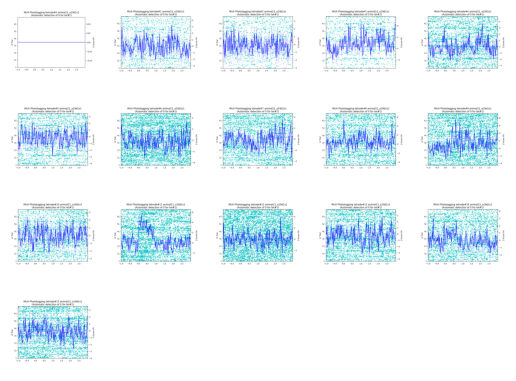

In [31]:
MUA_saving_folder = os.path.join(saving_folder, 'MUA')
os.makedirs(MUA_saving_folder, exist_ok=True)

apercu = []

for tet in tqdm(range(Ntet), total=Ntet, desc=f'Raster plots for MUA', leave=False):
        # plots(
        #         "plotRaster(SpikeTimesMUA, tet, color='c', xlabel=False, psth=True, psthcolor='blue', shadedcolor='blue', smooth=False, Plots=True)",
        #         suptitle=f"MUA Phototagging tetrode#{tet} {exp_id}\n(Automatic detection of 0 for tet#{LP_ref})",
        #         save = Saving_boolean,
        #         filename = os.path.join(MUA_saving_folder,f"MUA_phototagging_{exp_id}_tet#{tet}.png"),
        #         ncols=1,
        #         show=False
        # )
        plotRaster(SpikeTimesMUA, tet, color='c',
                        xlabel=False, 
                        psth=True, psthcolor='blue', shadedcolor='blue', smooth=False,
                        title=f"MUA Phototagging tetrode#{tet} {exp_id}\n(Automatic detection of 0 for tet#{LP_ref})",
                        save = Saving_boolean,
                        filename = os.path.join(MUA_saving_folder,f"MUA_phototagging_{exp_id}_tet#{tet}.png"),
                        show=False)
        apercu.append(os.path.join(MUA_saving_folder,f"MUA_phototagging_{exp_id}_tet#{tet}.png"))

plt.figure()

ncolonne = 5
nligne = len(apercu)//ncolonne + 1

for i in range(ncolonne*nligne):
        if i < len(apercu):
                img = plt.imread(apercu[i])
                plt.subplot(nligne, ncolonne, i+1)
                plt.imshow(img)
                plt.axis('off')
        else:
                plt.subplot(nligne, ncolonne, i+1)
                plt.axis('off')

plt.show()

# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>SUA Analysis</strong></span>

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>All Spiking Times</strong></span>

In [32]:
AllSpikeTimes = np.empty((Nclust, Ntrial), dtype=object)


for unit in range(Nclust):
    spikingTimeClus = temp_time_clust[unit]

    for trial in range(Ntrial):
        upperTime = peaks[trial] / f + timeAft
        lowerTime = peaks[trial] / f - timeBef
        rectifierTime = - lowerTime - timeBef

        bornes = np.logical_and(lowerTime < spikingTimeClus, spikingTimeClus < upperTime)

        AllSpikeTimes[unit][trial] = spikingTimeClus[bornes] + rectifierTime

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spiking times according to condition</strong></span>

In [33]:
SpikeTimes = [[] for _ in range(Nclust)]

for neuron in range(len(AllSpikeTimes)):
    for trial in range(Ntrial):
        SpikeTimes[neuron].append([AllSpikeTimes[neuron][trial]])


for unit in range(len(SpikeTimes)):
    SpikeTimes[unit] = np.array([SpikeTimes[unit][trial][0] for trial in range(len(SpikeTimes[unit]))], dtype=object)

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Raster plots</strong></span>

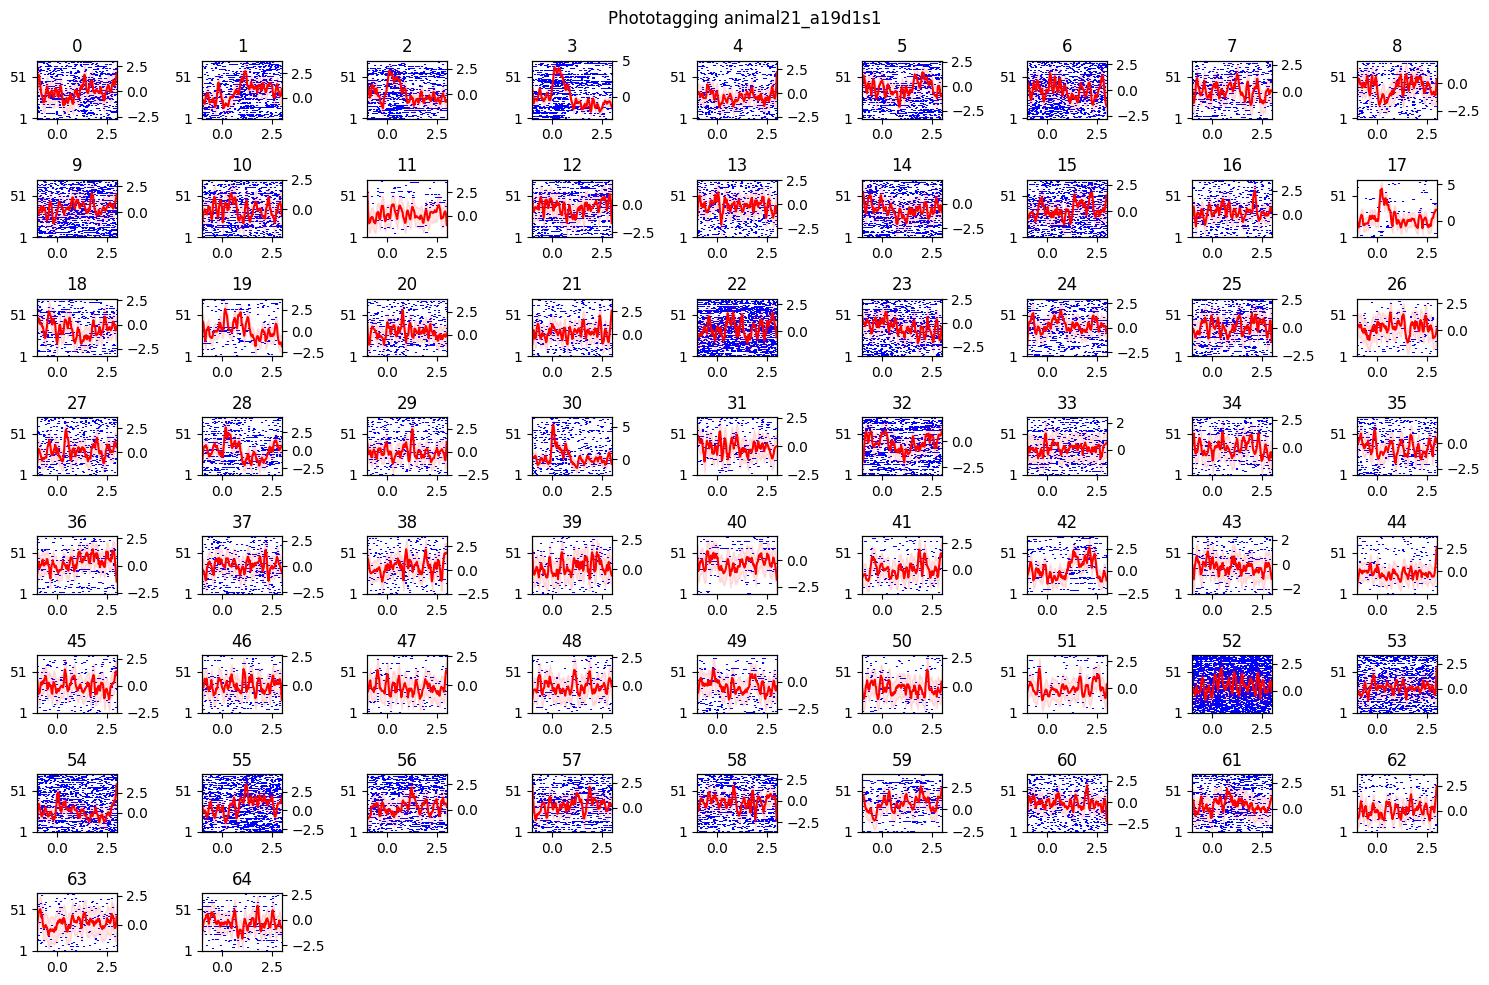

In [34]:
Raster_saving_folder = os.path.join(saving_folder, 'Raster')
os.makedirs(Raster_saving_folder, exist_ok=True)

plots(
    *[f"plotRaster(SpikeTimes, {unit}, Plots=True, xlabel=False, ylabel=False, title='{unit}', color='blue', psth=True, psthcolor='red', shadedcolor='red')" for unit in range(Nclust)],
    suptitle=f"Phototagging {exp_id}",
    save=Saving_boolean,
    filename=os.path.join(Raster_saving_folder, f"Raster_{exp_id}_phototagging.png"),
    size=(15,10)
)

In [35]:
All_raster_saving_folder = os.path.join(saving_folder, 'Raster', 'All')
os.makedirs(All_raster_saving_folder, exist_ok=True)

for unit in tqdm(range(Nclust), total=Nclust, desc=f'Raster plots for all units', leave=False):
    plotRaster(SpikeTimes, unit,
               color='blue',
               psth=True, psthcolor='red', shadedcolor='red',
               xlabel=True, ylabel=True,
               title=f'Unit {unit}, {exp_id}',
               show=False,
               save=True,
               filename=os.path.join(All_raster_saving_folder, f"Raster_{exp_id}_phototagging_unit{unit}.png"))

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>PSTH Heatmap</strong></span>

In [36]:
# Zmaxiscore = [[] for _ in range(len(SpikeTimes['first']['CW']))]

# for unit in range(len(SpikeTimes['first']['CW'])):
#     StudiedSpikeTimes = SpikeTimes['first']['CW'][unit]

#     color='k'
#     shadedcolor='k'
#     ylabel=True
#     xlabel=True

#     local_trial_number = len(StudiedSpikeTimes)

#     binResolution=0.03

#     spike_number_per_trial = [[] for _ in range(local_trial_number)]
#     edges = []
#     unitary_firing_rate = [[] for _ in range(local_trial_number)]

#     for trial in range(local_trial_number):
#         spike_number_per_trial[trial], edges = np.histogram(StudiedSpikeTimes[trial], bins=np.arange(-timeBef, timeAft + binResolution, binResolution))

#     frequency_per_trial = [[spike_number_per_trial[trial][bin]/binResolution for bin in range(len(edges)-1)] for trial in range(local_trial_number)]
#     mean_frequency = [np.mean([frequency_per_trial[trial][bin] for trial in range(local_trial_number)]) for bin in range(len(edges)-1)]

#     Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency)
#     Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency)
#     SEM = np.std(Zunitary)/np.sqrt(len(Zunitary))

#     # # plt.figure(figsize=(15,6))
#     # plt.plot(edges[:-1], Zscore, color=color)
#     # plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.1, color=shadedcolor)
#     # plt.xlim(-timeBef,timeAft)
#     # if ylabel:
#     #     plt.ylabel('PSTH')
#     # if xlabel:
#     #     plt.xlabel('Time (s)')
#     # plt.show()

#     Zmaxiscore[unit] = Zscore



# # del Zmaxiscore[22]


# # # Créer des données aléatoires pour le heatmap (une matrice 10x10)
# # data = np.random.rand(10, 100)

# # Afficher le heatmap
# plt.figure(figsize=(15, 5))
# plt.imshow(Zmaxiscore, cmap='coolwarm', interpolation='nearest', vmin=-2,vmax=2)
# plt.colorbar()  # Ajouter une barre de couleur pour référence
# # plt.xticks(duration)
# plt.show()

## <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Statistics</strong></span>

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Spike counting</strong></span>

In [37]:
numberBef, numberDur, diffBefDur, sumBefDur = ([[] for _ in range(Nclust)] for _ in range(4))


windowDur = [0, 0.003]
windowBef = [-0.003, 0]

for unit in range(Nclust):
    for trial in range(len(SpikeTimes[unit])):
        fooSpike = SpikeTimes[unit][trial]
        numberBef[unit].append(np.sum((fooSpike < windowBef[1]) & (fooSpike > windowBef[0])))
        numberDur[unit].append(np.sum((fooSpike < windowDur[1]) & (fooSpike > windowDur[0])))
        diffBefDur[unit].append(numberDur[unit][-1] - np.mean(numberBef[unit][-1]))
        sumBefDur[unit].append(numberDur[unit][-1] + np.mean(numberBef[unit][-1]))

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Paired Wilcoxon Test</strong></span>

In [67]:
statistics, p_values = ([] for _ in range(2))


for unit in range(Nclust):
    try:
        results = wilcoxon(numberBef[unit], numberDur[unit])
        statistics.append(results[0])
        p_values.append(results[1])
    except ValueError:
        statistics.append(0)
        p_values.append(1)
    
p_values = np.array(p_values)
statistics = np.array(statistics)

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Determination of significant units by condition</strong></span>

In [39]:
p_value_threshold = 0.05

significance = []

significance = (np.arange(0,Nclust))[p_values<p_value_threshold]

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Visual Overview Of Spike Numbers Before & During</strong></span>

In [40]:
print(f"Mean number of spikes before phototagging : {np.mean([np.mean(numberBef[unit]) for unit in range(Nclust)])}")
print(f"Mean number of spikes during phototagging : {np.mean([np.mean(numberDur[unit]) for unit in range(Nclust)])}")

Mean number of spikes before phototagging : 0.007692307692307693
Mean number of spikes during phototagging : 0.00989010989010989


### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Resuming Modulations</strong></span>

In [41]:
modulation = [[] for _ in range(Nclust)]

for unit in range(Nclust):
    modulation[unit] = 1 if unit in significance else 0

# Convert lists -> NumPy
modulation = np.array(modulation)

In [42]:
path_phototagged = os.path.join(saving_folder, 'Modulation')
path_nonphototagged = os.path.join(saving_folder, 'Modulation', 'Not_modulated')
os.makedirs(path_phototagged, exist_ok=True)
os.makedirs(path_nonphototagged, exist_ok=True)


for i in range(Nclust):
    plt.figure()
    plt.eventplot(SpikeTimes[i])
    plt.axvspan(-0.004, -0.001, color='gray', alpha=0.2)
    plt.axvspan(0, 0.003, color='cyan', alpha=0.2)
    plt.xlim(-0.005, 0.005)
    plt.margins(y=0)
    text_x = -0.004
    text_y = len(SpikeTimes[i]) + 5
    text = f'''stats = {statistics[i]:.2f}
    p = {p_values[i]:.5f}'''
    box_props = dict(boxstyle='round', facecolor='white', edgecolor='black')
    plt.text(text_x, text_y, text, bbox=box_props, ha='center', va='center')

    if i in significance:
        plt.title(f'Phototagged Unit {i}')
        if Saving_boolean:
            plt.savefig(os.path.join(path_phototagged, f"Unit_{i}_phototagged.png"))
        plt.close()
    else:
        plt.title(f'Not Phototagged Unit {i}')
        if Saving_boolean:
            plt.savefig(os.path.join(path_nonphototagged, f"Unit_{i}_not_phototagged.png"))
        plt.close()

### <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Showing Numerical Results</strong></span>

In [43]:
print(f"Phototagged units : {significance}")

Phototagged units : [53 55]


# <span style="border: 2px solid #1c75c8; padding: 3px; background-color: #c5ddf6; color: black"><strong>Saving Variables</strong></span>

In [45]:
# if Saving_boolean:
#     phototagging_data = {
#         'exp_id': exp_id,
#         'timeBef': timeBef,
#         'timeAft': timeAft,
#         # 'refVa!lue': refValue,
#         'din': din,
#         # 'time': time,
#         'chanSpace': chanSpace,
#         'rotationSpeed': rotationSpeed,
#         'ProbeType': ProbeType,
#         # 'f': f,
#         'ML_pos': ML_pos,
#         'AP_pos': AP_pos,
#         # 'SpikeTimesMUA': SpikeTimesMUA,
#         'Ntrial': Ntrial,
#         # 'protocolSeparationIndex': limit,
#         'SpikeTimes': SpikeTimes,
#         # 'ref': ref,
#         'peaks': peaks,
#         'duration': duration,
#         'table_velocity': table_velocity,
#         'c_class': c_class,
#         'Nclust': Nclust,
#         'm_class': m_class,
#         # 'm_class_tet': m_class_tet,
#         'Nclust_mua': Nclust_mua,
#         'Ntet': Ntet,
#         'allBasem': allBasem,
#         'PkDepthUnit': PkDepthUnit,
#         'mapp': mapp,
#         'ArgallLayers': ArgallLayers,
#         'DepthTetrode': DepthTetrode,
#         'AllDepth': AllDepth,
#         'windowBef': windowBef,
#         'windowDur': windowDur,
#         'numberBef': numberBef,
#         'numberDur': numberDur,
#         'diffBefDur': diffBefDur,
#         'sumBefDur': sumBefDur,
#         'statistics': statistics,
#         'p_values': p_values,
#         'significance': significance,
#         'modulation': modulation
#     }




#     file = os.path.join(os.path.dirname(saving_folder), exp_id+"_phototagging_variables.pickle")
    
#     # from tqdm import tqdm
#     # with tqdm(total=100) as pbar:
#     #     jd.save(data, os.path.join(saving_folder, exp_id+"_data.json"), progress=lambda *args: pbar.update(100))
#     # jd.save(data, os.path.join(data_saving_folder, exp_id+"_data.json"))
        
#     # Sauvegarde des variables dans un fichier
#     with open(file, 'wb') as FILE_WRITTER:
#         pickle.dump(phototagging_data, FILE_WRITTER)
#         FILE_WRITTER.close()

In [48]:
if Saving_boolean:
    file = os.path.join(os.path.dirname(saving_folder), exp_id+"_phototagging_variables.npz")
    np.savez(file,
            exp_id = exp_id,
            timeBef = timeBef,
            timeAft = timeAft,
            # refValue = refValue,
            din = din,
            # time = time,
            chanSpace = chanSpace,
            rotationSpeed = rotationSpeed,
            ProbeType = ProbeType,
            f = f,
            ML_pos = ML_pos,
            AP_pos = AP_pos,
            # SpikeTimesMUA = SpikeTimesMUA,
            Ntrial = Ntrial,
            # protocolSeparationIndex = limit,
            SpikeTimes = SpikeTimes,
            # ref = ref,
            peaks = peaks,
            duration = duration,
            table_velocity = table_velocity,
            c_class = c_class,
            Nclust = Nclust,
            m_class = m_class,
            # m_class_tet = m_class_tet,
            Nclust_mua = Nclust_mua,
            Ntet = Ntet,
            allBasem = allBasem,
            PkDepthUnit = PkDepthUnit,
            mapp = mapp,
            ArgallLayers = ArgallLayers,
            DepthTetrode = DepthTetrode,
            AllDepth = AllDepth,
            windowBef = windowBef,
            windowDur = windowDur,
            numberBef = numberBef,
            numberDur = numberDur,
            diffBefDur = diffBefDur,
            sumBefDur = sumBefDur,
            statistics = statistics,
            p_values = p_values,
            significance = significance,
            modulation = modulation
            )
